<a href="https://colab.research.google.com/github/k1-furuya/rstan001/blob/main/%E3%83%99%E3%82%A4%E3%82%BAAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv("vouchers.csv")
df.head()

,Unnamed: 0,ID,BOG95SMP,BOG97SMP,JAM93SMP,SEX,AGE,AGE2,HSVISIT,SCYFNSH,...,REPT,NREPT,FINISH6,FINISH7,FINISH8,SEX_MISS,USNGSCH,HOURSUM,TAB3SMPL,WORKING3
0,1,NaN,0,0,0,NaN,NaN,NaN,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.0,0,0,0,1.0,NaN,12.0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.0,0,0,0,0.0,NaN,13.0,NaN,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.0,1,0,0,0.0,14.0,12.0,0.0,8,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5,4.0,1,0,0,1.0,14.0,12.0,0.0,8,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [4]:
# 分析に使用する変数を選択
columns = ['VOUCH0','SCYFNSH', 'FINISH6', 'REPT6', 'NREPT', 'INSCHL',
                    'FINISH7', 'PRSCH_C', 'FINISH8', 'TOTSCYRS', 'REPT']

# 選択した変数のみを含むデータフレームを作成
df = df[columns]

# 欠損値を含む行を削除
cleaned_df =df.dropna()

# 削除後のデータの基本統計量を表示
cleaned_df.describe()


,VOUCH0,SCYFNSH,FINISH6,REPT6,NREPT,INSCHL,FINISH7,PRSCH_C,FINISH8,TOTSCYRS,REPT
count,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000,1907.000000
mean,0.533298,7.256948,0.941793,0.140010,0.186156,0.863136,0.663870,0.660199,0.525957,3.389617,0.166230
std,0.499021,1.151234,0.234195,0.387107,0.441139,0.343794,0.472508,0.473766,0.499457,1.243137,0.372384
min,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
50%,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000
75%,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.000000
max,1.000000,11.000000,1.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000


In [5]:
# 目的変数yと説明変数Xの分離
y = cleaned_df.pop("VOUCH0")
X = cleaned_df.copy()

In [6]:
# 正規化の処理（お作法）
X -= X.mean()
X /= X.std()

display(X.head())

,SCYFNSH,FINISH6,REPT6,NREPT,INSCHL,FINISH7,PRSCH_C,FINISH8,TOTSCYRS,REPT
3,0.645440,0.248539,-0.361684,-0.421990,0.398099,0.711374,0.717234,0.949117,0.491002,-0.446393
4,0.645440,0.248539,-0.361684,-0.421990,0.398099,0.711374,0.717234,0.949117,0.491002,-0.446393
5,0.645440,0.248539,-0.361684,-0.421990,0.398099,0.711374,-1.393514,0.949117,0.491002,-0.446393
6,-0.223194,0.248539,-0.361684,1.844869,0.398099,0.711374,-1.393514,-1.053058,0.491002,2.239005
10,0.645440,0.248539,-0.361684,-0.421990,0.398099,0.711374,-1.393514,0.949117,0.491002,-0.446393


In [7]:
# 変数一覧をcolumnsに設定する
columns = X.columns.values

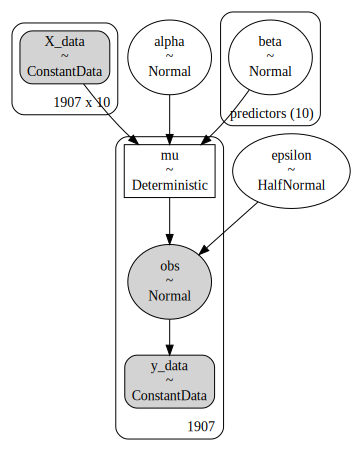

In [8]:
import pymc as pm
import arviz as az
# 無情報事前分布を用いたモデルの定義
with pm.Model(coords={'predictors': columns}) as model:
    # 定数データとしてXとyをモデルに追加
    X_data = pm.ConstantData('X_data', X)
    y_data = pm.ConstantData('y_data', y)

    # alpha（切片）の事前分布を設定
    alpha = pm.Normal('alpha', mu=0.0, sigma=1.0)

    # beta（各説明変数の係数）の事前分布を設定
    beta = pm.Normal('beta', mu=0.0, sigma=1.0, dims='predictors')

    # epsilon（誤差項の標準偏差）の事前分布を設定
    epsilon = pm.HalfNormal('epsilon', sigma=1.0)

    # mu（期待値）の計算
    mu = pm.Deterministic('mu', alpha + pm.math.dot(X_data, beta))

    # 観測データに基づく確率分布を定義
    obs = pm.Normal('obs', mu=mu, sigma=epsilon, observed=y_data)

# モデルのグラフィカルな表現を確認（省略可）
g = pm.model_to_graphviz(model)
g


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


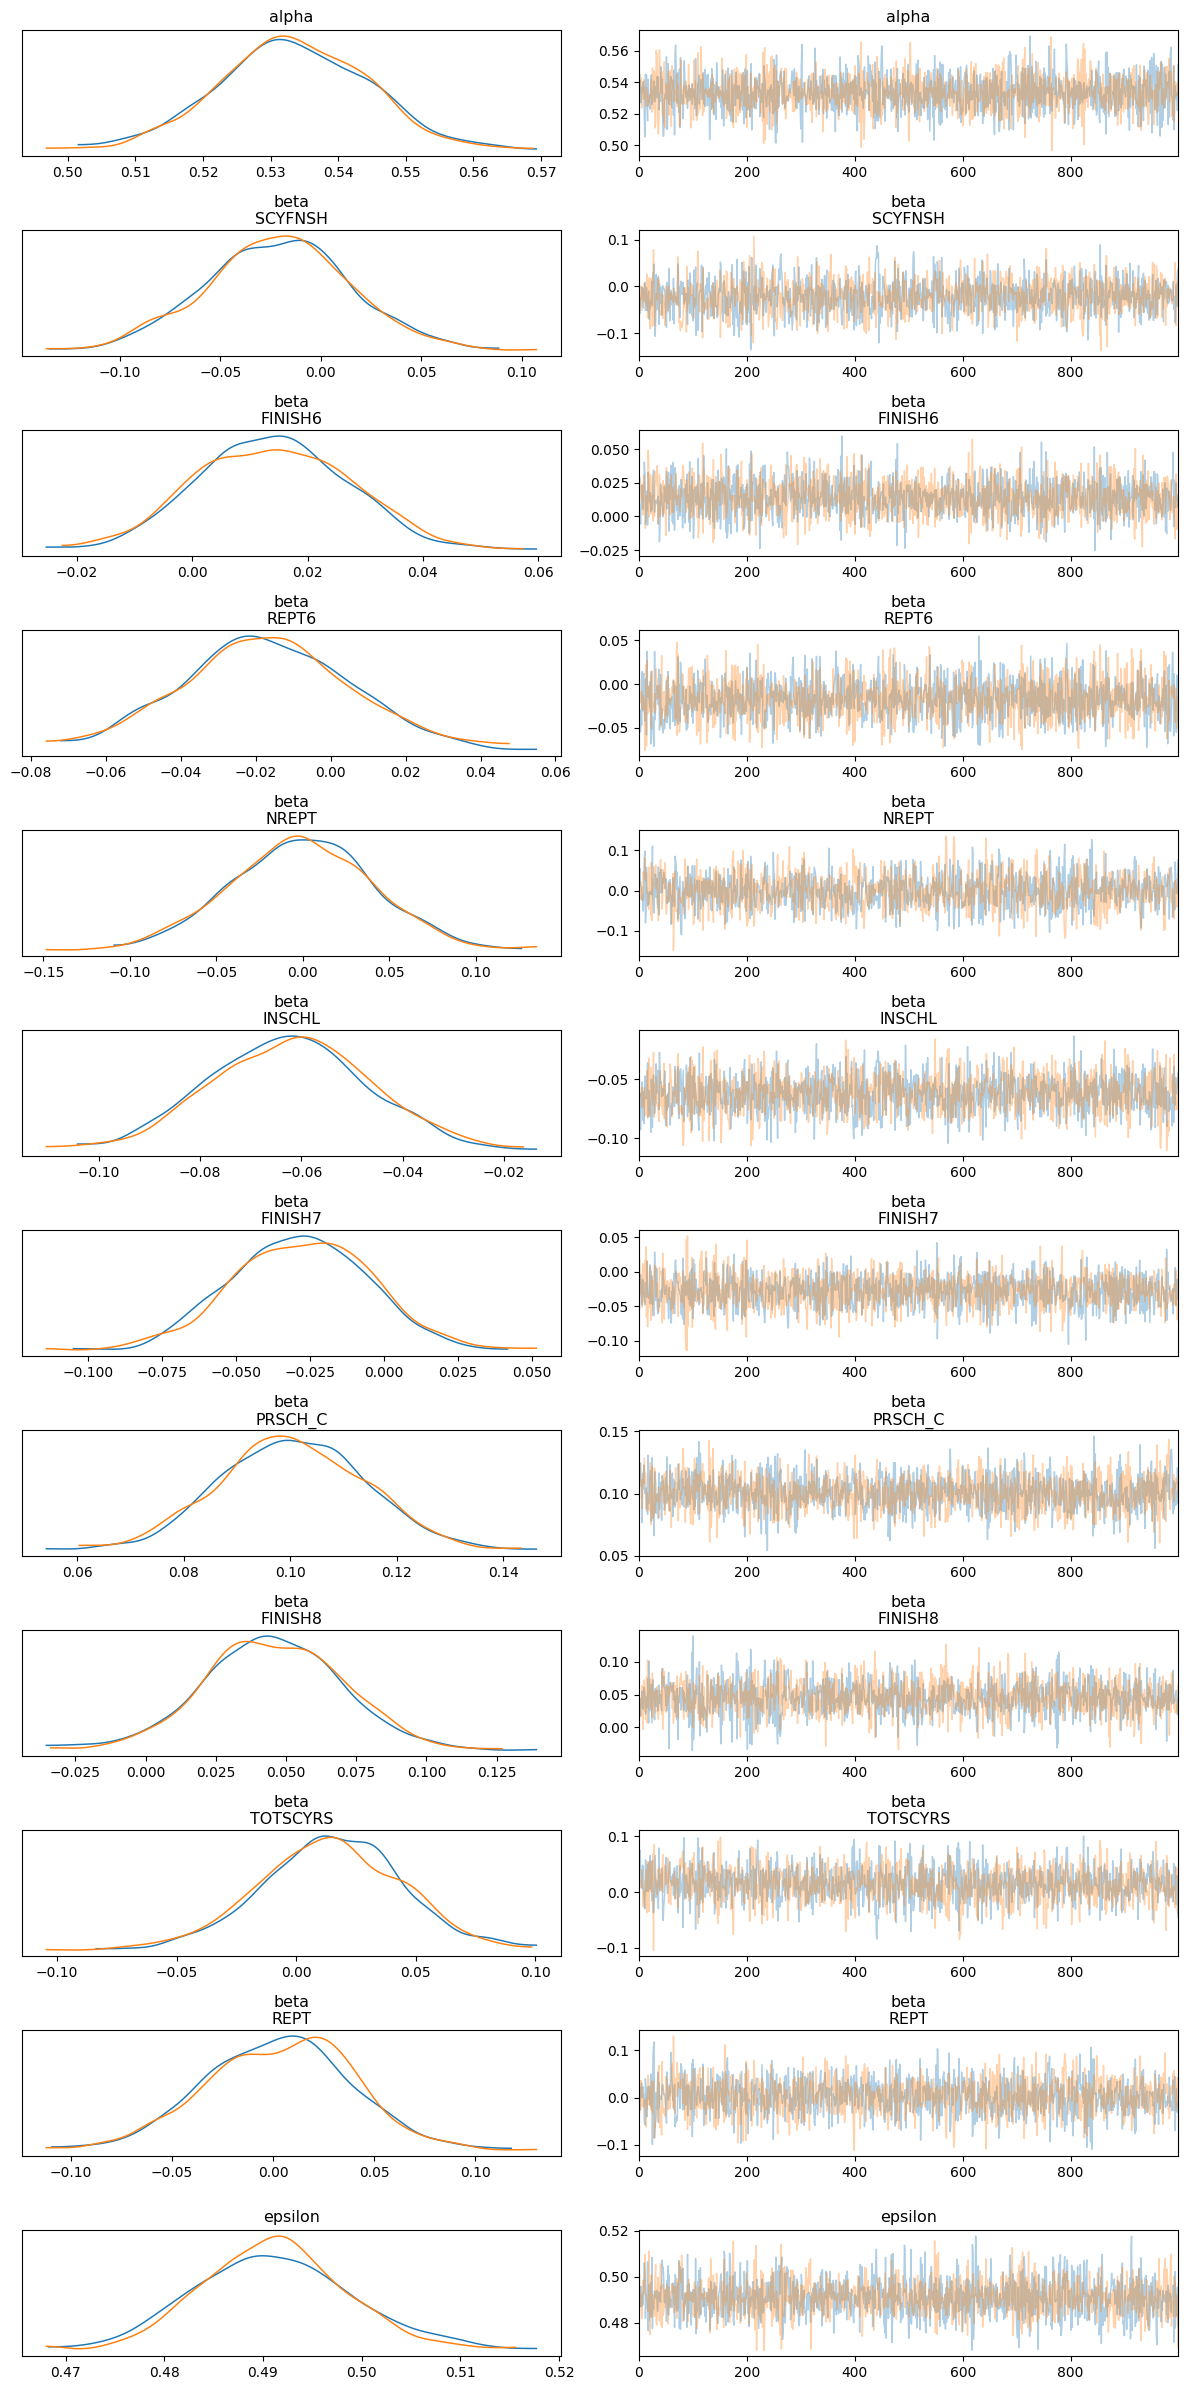

In [9]:
with model:
    idata1 = pm.sample(random_seed=42, target_accept=0.95)

# plot_trace関数で推論結果の確認
az.plot_trace(idata1, var_names=['alpha', 'beta', 'epsilon'], compact=False)
plt.tight_layout();

In [10]:
summary = az.summary(idata1, var_names=['alpha', 'beta', 'epsilon'])
summary

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.533,0.011,0.512,0.554,0.000,0.000,3077.0,1334.0,1.00
beta[SCYFNSH],-0.021,0.036,-0.088,0.046,0.001,0.001,1728.0,1282.0,1.00
beta[FINISH6],0.014,0.013,-0.010,0.039,0.000,0.000,2491.0,1542.0,1.00
beta[REPT6],-0.017,0.022,-0.059,0.026,0.000,0.000,2143.0,1451.0,1.00
beta[NREPT],-0.001,0.041,-0.075,0.078,0.001,0.001,1449.0,1386.0,1.00
beta[INSCHL],-0.062,0.016,-0.091,-0.034,0.000,0.000,1797.0,1361.0,1.00
beta[FINISH7],-0.028,0.023,-0.070,0.017,0.000,0.000,2572.0,1475.0,1.01
beta[PRSCH_C],0.100,0.014,0.075,0.125,0.000,0.000,2031.0,1457.0,1.00
beta[FINISH8],0.045,0.025,-0.002,0.091,0.001,0.000,2009.0,1200.0,1.00
beta[TOTSCYRS],0.014,0.030,-0.042,0.071,0.001,0.001,1784.0,1432.0,1.00


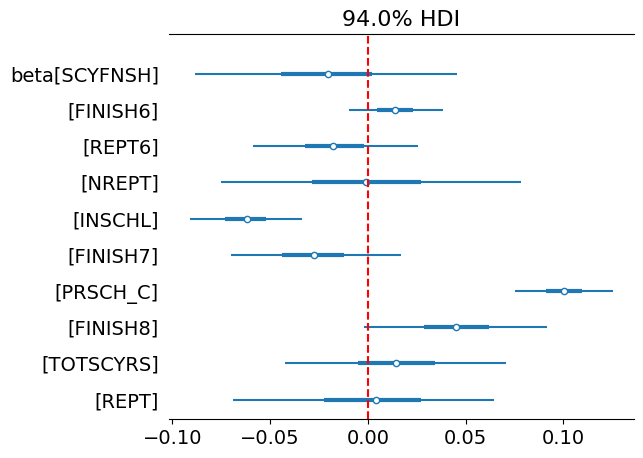

In [11]:
az.plot_forest(idata1, combined=True, var_names=[ 'beta'])

# 特定の位置に縦線を追加
plt.axvline(x=0.0, color='r', linestyle='--')

# 表示
plt.show()

PRSCH_C 当選から3年経過した調査の段階で私立学校に通っているかどうか

INSCHL 私立と公立を問わず通学の傾向を示す

REPT6 6年生で留年したかを示す

NREPT 3年間で何回留年したかを示す

REPT 調査までに一度でも留年したかを示す

FINISH6-8 当選から調査までの3年間で6,7,8年生の修了を表す